In [1]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())


['/device:CPU:0', '/device:GPU:0']


# Testing the Image Import

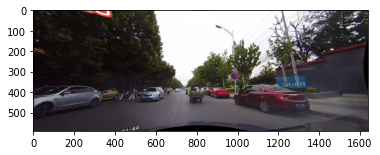

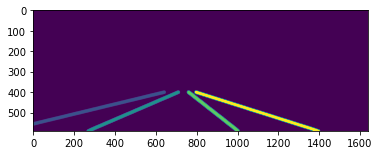

In [2]:
%matplotlib inline 
from PIL import Image
im = Image.open("D:/3MCS/Deep_Learning_In_Computer_Vision/CULane/CULane_Dataset/driver_161_90frame/06031231_0839.MP4/00090.jpg")

#id=100

import matplotlib.pyplot as plt
fig = plt.figure()
plt.imshow(im)
plt.show()

import imageio
import matplotlib.pyplot as plt
image_file= "D:/3MCS/Deep_Learning_In_Computer_Vision/CULane/CULane/labels/train/laneseg_label_w16/driver_161_90frame/06031231_0839.MP4/00090.png"
image_data = imageio.imread(image_file).astype(int)

id=100


fig = plt.figure()
plt.imshow(image_data)
plt.show()

Now That everything is set up we generate the train and test Data Sets, the import of ths Mask RCNN Model and the Coco dataset

# Libraries import

In [52]:
import os
import sys
import random
import math
import re
import time
import numpy as np
from tqdm import tqdm
import utils
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy
from config import Config
import utils
import model as modellib
import visualize
from model import log
import imageio
import matplotlib.pyplot as plt
import re
from PIL import Image
import os, sys
from tqdm import tqdm
import warnings
from multiprocessing import Pool
import numpy as np
from random import sample
import pickle
import scipy.misc

warnings.filterwarnings('ignore')
%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Config

In [4]:
class LanesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "lanes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4    # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8,16, 32, 64, 128) # anchor side in pixels
    
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 50

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 5000

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 500
    
    
    
config = LanesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           lanes
NUM_CLASSES                    5
POOL_SIZE                      7
POST_NMS_

# Notebook Preferences

In [5]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Data Set

## Resizing
As all images have diferent sizes we need to sesize all images to 128 x 128 pixels, because that size is the input of 128x128

## Training Set

## Original Images Lanes Images and Lanes record  

In [6]:
folder_images=  "D:/3MCS/Deep_Learning_In_Computer_Vision/CULane/CULane/images"
folder_lanes=  "D:/3MCS/Deep_Learning_In_Computer_Vision/CULane/CULane/labels/train"
train_image_list_path = []
train_image_list_color_path = []
train_lane=[]

with open('list2/train_gt.txt') as f:
    lines = f.read().splitlines()
    for record in tqdm(lines,desc="train files"): #assuming gif
        try:
            data= record.split()
            #print(data)
            train_image_list_path.append(folder_images +  data[0])
            train_image_list_color_path.append(folder_lanes +  data[1])
            x=[1,2,3,4]*np.array([int(data[2]),int(data[3]),int(data[4]),int(data[5])])
            train_lane.append(x)
            #image_list_path.append(folder_images +  filename)
        except (IOError, ValueError) as e:
            print('Could not read:', filename, ':', e, '- it\'s ok, skipping.')

train files: 100%|███████████████████████████████████████████████████████████| 23420/23420 [00:00<00:00, 187461.19it/s]


## Validation Set

In [7]:
import re
folder_images=  "D:/3MCS/Deep_Learning_In_Computer_Vision/CULane/CULane/images"
folder_lanes=  "D:/3MCS/Deep_Learning_In_Computer_Vision/CULane/CULane/labels/train"
val_image_list_path = []
val_image_list_color_path = []
val_lane=[]

with open('list2/val_gt.txt') as f:
    lines = f.read().splitlines()
    for record in tqdm(lines,desc="validation files"): #assuming gif
        try:
            data= record.split()
            #print(data)
            val_image_list_path.append(folder_images +  data[0])
            val_image_list_color_path.append(folder_lanes +  data[1])
            x=[1,2,3,4]*np.array([int(data[2]),int(data[3]),int(data[4]),int(data[5])])
            val_lane.append(x)
            #image_list_path.append(folder_images +  filename)
        except (IOError, ValueError) as e:
            print('Could not read:', filename, ':', e, '- it\'s ok, skipping.')

validation files: 100%|██████████████████████████████████████████████████████████| 547/547 [00:00<00:00, 136070.48it/s]


## Getting a Sample of  Images and Lanes

In [8]:
# #Making a Sample
# import numpy as np
# from random import sample
# l = len(train_image_list_path) #length of data
# print(l)
# f = 300 #300  #number of elements you need for sample
# indices = sample(range(l),f)

# type(train_image_list_path)
# sample_images = [train_image_list_path[i] for i in indices]
# sample_lanes = [train_image_list_color_path[i] for i in indices]
# samples_ids = [train_lane[i] for i in indices]

# l_test=len(val_image_list_path)
# print(l)
# f_test =20 #20 
# indices_test = sample(range(l_test),f_test)

# sample_images_test = [val_image_list_path[i] for i in indices_test]
# sample_lanes_test = [val_image_list_color_path[i] for i in indices_test]
# samples_ids_test = [val_lane[i] for i in indices_test]

In [9]:
# image=sample_images[10]

In [10]:
#Without a Sample
import numpy as np
from random import sample
l = len(train_image_list_path) #length of data 
print(l)
f =l #300  #number of elements you need for sample
indices = range(l)

type(train_image_list_path)
sample_images = [train_image_list_path[i] for i in indices]
sample_lanes = [train_image_list_color_path[i] for i in indices]
samples_ids = [train_lane[i] for i in indices]

l_test=len(val_image_list_path)
print(l_test)
f_test = l_test #20 
indices_test = sample(range(l_test),f_test)

sample_images_test = [val_image_list_path[i] for i in indices_test]
sample_lanes_test = [val_image_list_color_path[i] for i in indices_test]
samples_ids_test = [val_lane[i] for i in indices_test]

23420
547


In [11]:
image=sample_images[10]
image = sample_images_test[3]

In [12]:
#Image Resize
def resize(list_images,list_lanes,image_size_width,image_size_lenght):
    list_resize_image=[]
    list_resize_lanes=[]
    for image in tqdm(list_images,desc="Images"):
        try:
            image_data=Image.open(image)
            imResize = image_data.resize((image_size_width,image_size_lenght), Image.ANTIALIAS)
            filename, file_extension = os.path.splitext(image)
            name_file=filename+"_RESIZE"+file_extension
            imResize.save(name_file, 'PNG', quality=90)
            list_resize_image.append(name_file)
        except (IOError, ValueError) as e:
                print('Could not read:', image, ':', e, '- it\'s ok, skipping.')


    for lane in tqdm(list_lanes,desc="Lanes"):
        try:
            lanes_data=Image.open(lane)
            laneResize = lanes_data.resize ((image_size_width,image_size_lenght), Image.NEAREST)
            filename, file_extension = os.path.splitext(lane)
            name_file=filename+"_RESIZE"+file_extension
            laneResize.save(name_file, 'PNG', quality=90)
            list_resize_lanes.append(name_file)
        except (IOError, ValueError) as e:
                print('Could not read:', lane, ':', e, '- it\'s ok, skipping.')
            
    return(list_resize_image,list_resize_lanes)

In [13]:
(list_resize_image,list_resize_lanes)=resize(sample_images,sample_lanes,256,256)

Lanes: 100%|████████████████████████████████████████████████████████████████████| 23420/23420 [03:33<00:00, 109.81it/s]


In [14]:
(list_resize_image_test,list_resize_lanes_test)=resize(sample_images_test,sample_lanes_test,256,256)

Lanes: 100%|████████████████████████████████████████████████████████████████████████| 547/547 [00:04<00:00, 113.18it/s]


In [15]:
# #list_resize_lanes[66849]
# list_resize_lanes.remove('D:/3MCS/Deep_Learning_In_Computer_Vision/CULane/CULane/labels/train/laneseg_label_w16/driver_161_90frame/06040253_1057.MP4/00540_RESIZE.png')

In [16]:
len(list_resize_lanes)

23420

In [17]:
list_resize_image

['D:/3MCS/Deep_Learning_In_Computer_Vision/CULane/CULane/images/driver_161_90frame/06031137_0821.MP4/00000_RESIZE.jpg',
 'D:/3MCS/Deep_Learning_In_Computer_Vision/CULane/CULane/images/driver_161_90frame/06031137_0821.MP4/00090_RESIZE.jpg',
 'D:/3MCS/Deep_Learning_In_Computer_Vision/CULane/CULane/images/driver_161_90frame/06031137_0821.MP4/00180_RESIZE.jpg',
 'D:/3MCS/Deep_Learning_In_Computer_Vision/CULane/CULane/images/driver_161_90frame/06031137_0821.MP4/00270_RESIZE.jpg',
 'D:/3MCS/Deep_Learning_In_Computer_Vision/CULane/CULane/images/driver_161_90frame/06031137_0821.MP4/00360_RESIZE.jpg',
 'D:/3MCS/Deep_Learning_In_Computer_Vision/CULane/CULane/images/driver_161_90frame/06031137_0821.MP4/00450_RESIZE.jpg',
 'D:/3MCS/Deep_Learning_In_Computer_Vision/CULane/CULane/images/driver_161_90frame/06031137_0821.MP4/00540_RESIZE.jpg',
 'D:/3MCS/Deep_Learning_In_Computer_Vision/CULane/CULane/images/driver_161_90frame/06031137_0821.MP4/00630_RESIZE.jpg',
 'D:/3MCS/Deep_Learning_In_Computer_Visi

In [18]:
with open('list_Image_Resize.txt', 'wb') as fp:
    pickle.dump(list_resize_image, fp)

with open('list_Lane_Resize.txt', 'wb') as fp:
    pickle.dump(list_resize_lanes, fp)

with open('list_Image_Resize_test.txt', 'wb') as fp:
    pickle.dump(list_resize_image_test, fp)

with open('list_Lane_Resize_test.txt', 'wb') as fp:
    pickle.dump(list_resize_lanes_test, fp)
    
with open('list_sample_id.txt', 'wb') as fp:
    pickle.dump(samples_ids, fp)

with open('list_sample_id_test.txt', 'wb') as fp:
    pickle.dump(samples_ids_test, fp)
    


In [19]:
samples_ids = [train_lane[i] for i in range(23420)]
samples_ids_test = [val_lane[i] for i in range(547)]

In [20]:
# #/home/facundo/assignment1/Culanes/images/driver_161_90frame/06040253_1057.MP4/00540.jpg
# train_image_list_path.index("D:/3MCS/Deep_Learning_In_Computer_Vision/CULane/CULane_Dataset/driver_161_90frame/06031231_1039.MP4/04500.jpg")
# samples_ids.pop(train_image_list_path.index("D:/3MCS/Deep_Learning_In_Computer_Vision/CULane/CULane_Dataset/driver_161_90frame/06031231_1039.MP4/04500.jpg"))
len(samples_ids)

23420

# Read Resizes Images

In [21]:
import pickle
with open ('list_Image_Resize.txt', 'rb') as fp:
    sample_images = pickle.load(fp)

    
with open ('list_Lane_Resize.txt', 'rb') as fp:
    sample_lanes = pickle.load(fp)
    
with open ('list_Image_Resize_test.txt', 'rb') as fp:
    sample_images_test = pickle.load(fp)

    
with open ('list_Lane_Resize_test.txt', 'rb') as fp:
    sample_lanes_test = pickle.load(fp)
    
with open ('list_sample_id.txt', 'rb') as fp:
    samples_ids = pickle.load(fp)

    
with open ('list_sample_id_test.txt', 'rb') as fp:
    samples_ids_test = pickle.load(fp)
    

D:/3MCS/Deep_Learning_In_Computer_Vision/CULane/CULane/labels/train/laneseg_label_w16/driver_161_90frame/06031137_0821.MP4/00900_RESIZE.png


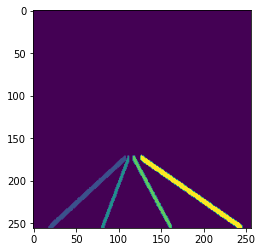

In [22]:
print(sample_lanes[10])
image_data = imageio.imread(sample_lanes[10]).astype(int)

fig = plt.figure()
plt.imshow(image_data)
plt.show()

D:/3MCS/Deep_Learning_In_Computer_Vision/CULane/CULane/images/driver_161_90frame/06031137_0821.MP4/00900_RESIZE.jpg


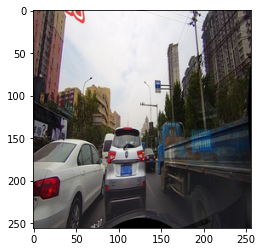

In [23]:
print(sample_images[10])
image_data = imageio.imread(sample_images[10]).astype(int)

fig = plt.figure()
plt.imshow(image_data)
plt.show()

In [24]:
pixel_depth = 255  # Number of levels per pixel.

def load_lane(list_images,list_lanes,image_size_width,image_size_lenght,image_colors_image,image_colors_lane):
    """Load the data for a single letter label."""
    
    
    dataset_image = np.ndarray(shape=(len(list_images), image_size_lenght,image_size_width, image_colors_image),
                         dtype=np.uint8)
    
    dataset_lane = np.ndarray(shape=(len(list_lanes), image_size_lenght,image_size_width),
                         dtype=np.uint8)
    num_images = 0

    for image in tqdm(list_images,desc="Images"):
        try:
            image_data=Image.open(image)
            dataset_image[num_images, :, :] = image_data
            num_images = num_images + 1
        except (IOError, ValueError) as e:
            print('Could not read:', image, ':', e, '- it\'s ok, skipping.')
    num_images = 0
    
    for lane in tqdm(list_lanes,desc="Lanes"):
        try:
            lanes_data=Image.open(lane)
            #lanes_data=imageio.imread(lane).astype(int)
            dataset_lane[num_images, :, :] = lanes_data
            num_images = num_images + 1
        except (IOError, ValueError) as e:
            print('Could not read:', lane, ':', e, '- it\'s ok, skipping.')
      
    return (dataset_image,dataset_lane)

In [25]:
(train_images,train_lanes)=load_lane(sample_images,sample_lanes,256,256,3,256)

Lanes: 100%|████████████████████████████████████████████████████████████████████| 23420/23420 [00:58<00:00, 400.19it/s]


In [26]:
#(test_images,test_lanes,list_images_resize_test,list_lanes_resize_test)=load_lane(sample_images_test,sample_lanes_test,256,256,3,256)
(test_images,test_lanes)=load_lane(sample_images_test,sample_lanes_test,256,256,3,256)

Lanes: 100%|████████████████████████████████████████████████████████████████████████| 547/547 [00:01<00:00, 421.90it/s]


## Class Lanes

In this Class we define the Photos and the Shapes of each lane, for the algorithm to understand and generalize.

In [27]:
class LanesDataset(utils.Dataset):
 
    dir_images=[]
    dir_lanes=[]
    width=256
    lenght=256
    images=np.ndarray(shape=(1, lenght,width, 3),dtype=np.uint8)
    lanes=np.ndarray(shape=(1, lenght,width),dtype=np.uint8)
    samples_ids=[]
    
    def load_LanesDataset(self, dir_images,dir_lanes,images,lanes,samples_ids):
        self.dir_images = dir_images
        self.dir_lanes=dir_lanes
        self.images=images
        self.lanes=lanes
        self.samples_ids=samples_ids

    def convert_mask(self,image,figures,height,width):
        
        maskblack = np.all(image == (0, 0, 0), axis=-1)
        shapes=figures
        zeros=shapes[shapes==0]
        shapes=shapes[shapes!=0]

        num_shapes=len(shapes)
        pixels = np.ndarray(shape=(height,width,num_shapes),dtype=np.uint8)

        pixels = numpy.zeros(((height,width,num_shapes)))
        
        
        if shapes.any():
            k=0
            for shape in shapes:
                pos=np.where( image == shape )
                pixels[:,:,k][pos]=1
                k=k+1

        return (shapes,pixels)
            
    def load_lanes(self,count, height, width):
        self.add_class("lanes", 1, "lane_1")
        self.add_class("lanes", 2, "lane_2")
        self.add_class("lanes", 3, "lane_3")
        self.add_class("lanes", 4, "lane_4")
        self.width=width
        self.height=height
        item = list(range(count))
        i=0
        for sample_image in tqdm(self.dir_images,desc="Images"):
            #Gives back a vector of shapes with the shapes in the image (forward and/or backward in our case) and position 
            imageshape=self.lanes[i]
            figures=self.samples_ids[i]
            shape,mask=self.convert_mask(imageshape,figures,self.height,self.width)
            self.add_image("lanes",image_id=i,path=sample_image,lanes=shape)  
            i=i+1
   

    def load_image(self, image_id):
        "Load The real Image from a file"
        info = self.image_info[image_id]
        image=self.images[image_id]

        return image
    
    def load_mask(self, image_id):
        "Load the masks for each file, returns the arrays of Masks and the id's per mask "
        info = self.image_info[image_id]
        imagemask=self.lanes[image_id]
        figures=self.samples_ids[image_id]
        (shape,mask)=self.convert_mask(imagemask,figures,self.height,self.width)  
        return mask, shape.astype(np.int32)
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info["lanes"]
    

In [28]:
dataset_train = LanesDataset()
dataset_train.load_LanesDataset(sample_images,sample_lanes,train_images,train_lanes,samples_ids)
dataset_train.load_lanes(len(train_images), 256,256)
dataset_train.prepare()


Images: 100%|██████████████████████████████████████████████████████████████████| 23420/23420 [00:20<00:00, 1159.17it/s]


In [29]:
dataset_val = LanesDataset()
dataset_val.load_LanesDataset(sample_images_test,sample_lanes_test,test_images,test_lanes,samples_ids_test)
dataset_val.load_lanes(len(test_images), 256,256)
dataset_val.prepare()

Images: 100%|██████████████████████████████████████████████████████████████████████| 547/547 [00:00<00:00, 2461.68it/s]


# Testing some images and their lane ground truth

In [30]:
del sample_images
del sample_lanes
del sample_images_test
del sample_lanes_test
del samples_ids
del samples_ids_test
del train_images
del train_lanes
del test_images
del test_lanes

In [4]:
# # Load and display random samples from the training set

# image_ids = range(0,10)

# for image_id in image_ids:
#     print(image_id)
    
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
#     unique_class_ids = np.unique(class_ids)
#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names,limit=4)

 # Create the Model

In [51]:
# Create model in training mode
import importlib
importlib.reload(modellib)

<module 'model' from 'C:\\Users\\promo\\anaconda3\\envs\\cuda\\Computer Vision\\MASK_Lane_Detection-master\\model.py'>

In [74]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [75]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "coco":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, 
            layers='5+')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\promo\anaconda3\envs\cuda\Computer Vision\MASK_Lane_Detection-master\logs\lanes20200925T1545\mask_rcnn_lanes_{epoch:04d}.h5
Selecting layers to train
res5a_branch2a         (Conv2D)
bn5a_branch2a          (BatchNorm)
res5a_branch2b         (Conv2D)
bn5a_branch2b          (BatchNorm)
res5a_branch2c         (Conv2D)
res5a_branch1          (Conv2D)
bn5a_branch2c          (BatchNorm)
bn5a_branch1           (BatchNorm)
res5b_branch2a         (Conv2D)
bn5b_branch2a          (BatchNorm)
res5b_branch2b         (Conv2D)
bn5b_branch2b          (BatchNorm)
res5b_branch2c         (Conv2D)
bn5b_branch2c          (BatchNorm)
res5c_branch2a         (Conv2D)
bn5c_branch2a          (BatchNorm)
res5c_branch2b         (Conv2D)
bn5c_branch2b          (BatchNorm)
res5c_branch2c         (Conv2D)
bn5c_branch2c          (BatchNorm)
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Co

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_lanes.h5")
model.keras_model.save_weights(model_path)

In [ ]:
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE, 
#             epochs=30, 
#             layers='5+')
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_lanes.h5")
# model.keras_model.save_weights(model_path)

In [38]:
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE, 
#             epochs=40, 
#             layers='5+')
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_lanes.h5")
# model.keras_model.save_weights(model_path)

# Detection

In [47]:
class InferenceConfig(LanesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\Users\promo\anaconda3\envs\cuda\Computer Vision\MASK_Lane_Detection-master\logs\lanes20200925T0845\mask_rcnn_lanes_0015.h5


original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max:  256.00000  int32
gt_class_id              shape: (3,)                  min:    2.00000  max:    4.00000  int32
gt_bbox                  shape: (3, 4)                min:   75.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 3)         min:    0.00000  max:    1.00000  float64


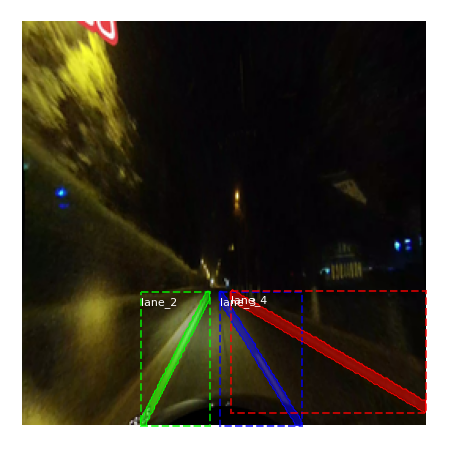

array([[[128, 118,  22],
        [141, 132,  33],
        [158, 149,  43],
        ...,
        [  4,   2,   5],
        [  5,   3,   6],
        [  5,   3,   6]],

       [[130, 120,  25],
        [135, 125,  29],
        [150, 140,  39],
        ...,
        [  5,   3,   6],
        [  5,   3,   6],
        [  5,   3,   6]],

       [[141, 131,  34],
        [139, 129,  35],
        [142, 131,  37],
        ...,
        [  5,   3,   6],
        [  5,   3,   6],
        [  5,   3,   6]],

       ...,

       [[144, 129,  46],
        [152, 136,  51],
        [144, 130,  41],
        ...,
        [ 21,  17,   5],
        [ 23,  19,   7],
        [ 26,  20,   8]],

       [[144, 129,  45],
        [146, 130,  45],
        [144, 129,  38],
        ...,
        [ 20,  16,   4],
        [ 21,  17,   5],
        [ 24,  18,   6]],

       [[142, 127,  43],
        [143, 127,  41],
        [149, 134,  40],
        ...,
        [ 21,  17,   5],
        [ 20,  16,   4],
        [ 22,  16,   4]]

In [53]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

## Evaluate in non trained Data

In [64]:
import re
folder_images=  "D:/3MCS/Deep_Learning_In_Computer_Vision/CULane/CULane/test"
test_image_list_path = []
val_lane=[]

with open('list2/test0.txt') as f:
    lines = f.read().splitlines()
    for record in tqdm(lines): #assuming gif
        try:
            data= record.split()
            #print(data)
            test_image_list_path.append(folder_images +  data[0])

        except (IOError, ValueError) as e:
            print('Could not read:', filename, ':', e, '- it\'s ok, skipping.')

100%|█████████████████████████████████████████████████████████████████████████| 3357/3357 [00:00<00:00, 1626273.80it/s]


In [65]:

l_val=len(test_image_list_path)
f_val =30 
indices_val = sample(range(l_val),f_val)
#indices_val = range(l_val)

sample_images_val = [test_image_list_path[i] for i in indices_val]
sample_lanes_val = []
samples_ids_val = []

In [66]:
(list_resize_image_val,list_resize_lanes_val)=resize(sample_images_val,sample_lanes_val,256,256)

Images: 100%|██████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.13it/s]
Lanes: 0it [00:00, ?it/s]


In [67]:
(val_images,val_lanes)=load_lane(list_resize_image_val,list_resize_lanes_val,256,256,3,256)


#dataset_val = LanesDataset()
#dataset_val.load_LanesDataset(sample_images_val,sample_lanes_val,train_images,train_lanes)
#dataset_val.load_lanes(f, 256,256,)
#dataset_val.prepare()

Images: 100%|█████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 237.11it/s]
Lanes: 0it [00:00, ?it/s]


In [68]:
with open('list_val_images.txt', 'wb') as fp:
    pickle.dump(val_images, fp)

#with open('list_val_lanes.txt', 'wb') as fp:
#    pickle.dump(val_lanes, fp)

In [69]:
with open ('list_val_images.txt', 'rb') as fp:
    val_images = pickle.load(fp)

    
#with open ('list_val_lanes.txt', 'rb') as fp:
#    val_lanes = pickle.load(f|p)
    

In [70]:
class InferenceConfig(LanesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\Users\promo\anaconda3\envs\cuda\Computer Vision\MASK_Lane_Detection-master\logs\lanes20200925T0845\mask_rcnn_lanes_0015.h5


In [1]:
# im=val_images[5]
# #im.size #196608
# results = model.detect([im], verbose=0)
# r = results[0]
# image_out= visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
#                                 dataset_train.class_names, r['scores'], ax=get_ax())
# type(image_out)
# from keras.preprocessing.image import array_to_img
# rgb = array_to_img(image_out)
# imResize = rgb.resize((750,300), Image.ANTIALIAS)
# imResize.save('5.jpg')

In [2]:
# #image_ids = np.random.choice(list(range(len(dataset_test_org[0]))), 20)
# #image_ids=[260,2]
# from PIL import Image

# PATH_OUT=  "D:/3MCS/Deep_Learning_In_Computer_Vision/CULane/CULane/test/Output"
# i=0
# for im in val_images:
#     original_image= im
#     #fig = plt.figure()
#     #plt.imshow(original_image)
#     #plt.show()
#     results = model.detect([original_image], verbose=0)

#     r = results[0]

#     #print(r['masks'])
        
#     image_out= visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
#                                 dataset_train.class_names, r['scores'], ax=get_ax())
#     #cv2.imwrite(os.path.join(PATH_OUT , str(i) + '.jpg'), image_out)
#     #img = Image.fromarray(image_out,'RGB')
#     rgb = array_to_img(image_out)
#     imResize = rgb.resize((750,300), Image.ANTIALIAS)
#     imResize.save(PATH_OUT+'/'+ str(i) +'.jpg')
#     #img.save(os.path.join(PATH_OUT , str(i) + '.jpg'),'PNG', quality=100)
#     #print(img)
#     #fig = plt.figure()
#     #plt.imshow(image_out)
#     #plt.show()
#     i=i+1

In [3]:
# for im in val_images:
#     original_image= im
#     fig = plt.figure()
#     plt.imshow(original_image)
#     plt.show()
#     results = model.detect([original_image], verbose=0)

#     r = results[0]

#     #print(r['masks'])
        
#     r = results[0]
#     good=np.where(r['scores'] > 0.80)
    
#     j=len(good[0])
#     scores=r['scores'][np.where(r['scores'] > 0.8)]
#     class_ids=r['class_ids'][np.where(r['scores'] > 0.8)]
#     rois=r['rois'][np.where(r['scores'] > 0.8)]
#     print(len(r['scores']))
#     masks=r['masks']
#     masks=r['masks'][:,:,0:j]

#     visualize.display_instances(original_image, rois, masks, class_ids, 
#                                 dataset_train.class_names, scores, ax=get_ax())    
        